In [2]:
## Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LayerNormalization

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [2]:
## Datasets
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

# Prevendo uma Sequência Temporal
- Se houver tendendência é mais adequado remover e acrescentar depois.
- Caso haja sazonalidade, é mais adequado fazer a diferenciação com o mesmo período do ano anterior.

## Métricas de Baseline

In [5]:
## Naive: última amostra - 0.02 MSE - 0,14 RMSE
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0062

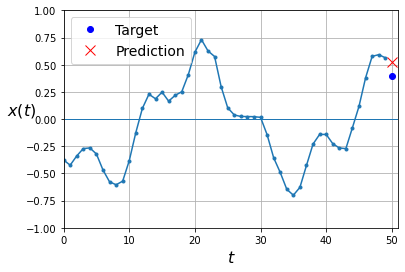

In [7]:
## Predição Linear - 0,004 MSE - 0,06 RMSE
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Implementando uma RNN Simples

In [3]:
## 0,00262 MSE - 0,051 RMSE 
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), ## descobramentos no tempo
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 5s 13ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0030 - val_lo

0.0026236227713525295

## Prevendo Múltiplos Passos a Frente
- Utilizar a rede anterior não dá bons resultados: é melhor que o Modelo Naive, mas pior que o Modelo Linear.
- Pode-se usar também Monte Carlo Dropout para adicionar barras de erro às predições.

In [7]:
## Novo Dataset
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [9]:
## Treinando a Rede para Prever Múltiplos Passos a Frente - 0.0085 MSE - 0,092 RMSE
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 5s 12ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0110 - val_lo

0.008533011190593243

In [3]:
## Fazendo a rede prever múltiplos passos a cada passo - Sequence to Sequence - 0,0058 MSE - 0,076 RMSE 

np.random.seed(43)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]
print(X_train.shape, Y_train.shape)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
model.evaluate(X_valid, Y_valid)

(7000, 50, 1) (7000, 50, 10)
Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0496 - last_time_step_mse: 0.0394 - val_loss: 0.0425 - val_last_time_step_mse: 0.0318
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0397 - last_time_step_mse: 0.0296 - val_loss: 0.0352 - val_last_time_step_mse: 0.0251
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0381 - last_time_step_mse: 0.0296 - val_loss: 0.0367 - val_last_time_step_mse: 0.0290
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0328 - last_time_step_mse: 0.0230 - val_loss: 0.0298 - val_last_time_step_mse: 0.0180
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0290 - last_time_step_mse: 0.0182 - val_loss: 0.0271 - val_last_time_step_mse: 0.0152
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0258 - last_time_step_mse: 0.0139 - val_loss: 0.0246 - val_last_time_step_mse: 

[0.018091678619384766, 0.005858028307557106]

# Lindando com Sequências Longas

## Lidando com Gradientes Explosivos - Normalização

In [4]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [5]:
## Treinando
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 32ms/step - loss: 0.1609 - last_time_step_mse: 0.1531 - val_loss: 0.0763 - val_last_time_step_mse: 0.0645
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0642 - last_time_step_mse: 0.0509 - val_loss: 0.0575 - val_last_time_step_mse: 0.0424
Epoch 3/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0536 - last_time_step_mse: 0.0396 - val_loss: 0.0504 - val_last_time_step_mse: 0.0352
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0475 - last_time_step_mse: 0.0332 - val_loss: 0.0464 - val_last_time_step_mse: 0.0320
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0432 - last_time_step_mse: 0.0291 - val_loss: 0.0430 - val_last_time_step_mse: 0.0294
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0394 - last_time_step_mse: 0.0255 - val_loss: 0.0380 - val_last_time_step_mse: 0.0239
Epoch 7/20
219/219 [=

## Lidando com Memórias de Curto e Longo Prazo